In [11]:
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import argparse 
import sys
import os

sys.path.insert(0, "Epidemiology_behavior_dynamics/run")
import config as cf


In [9]:
main_path = os.path.split(os.getcwd())[0] 
config_path = main_path + '/config.csv'

config_data = pd.read_csv(config_path, sep=',', header=None, index_col=0)
config_data


config_data = pd.read_csv(config_path, sep=',', header=None, index_col=0)

networks_path = config_data.loc['networks_dir'][1]
results_path  = config_data.loc['results_dir'][1] + '/elasticity_test'
figures_path  = config_data.loc['figures_dir'][1]
awareness_path = config_data.loc['sigma_search_dir'][1]
infection_prob_path = config_data.loc['beta_search_dir'][1]
num_nodes     = 1000

sigma_search = pd.read_csv(os.path.join(main_path, awareness_path), dtype={'key':str, 'value':float})
beta_search  = pd.read_csv(os.path.join(main_path, infection_prob_path), dtype={'key':str, 'value':float})
strategies_res = ['cooperate','defect']
fixed_strategies = [0.1, 0.5, 0.25]
schemes = ['global','local']

time2Recover = (1/7)  # gamma

df = pd.concat([sigma_search, beta_search], axis=1)

list_df = []

for strat in strategies_res:
    for fixed_frac in fixed_strategies:
        for type_sim in schemes:

            df_param_run = pd.DataFrame(columns=['beta_key', 'sigma_key', 'beta_val', 'sigma_val', 'R0'])

            beta_key  = []
            sigma_key = []
            beta_val  = []
            sigma_val = []
            R0_val    = []
            for idx_sigma , r_sigma in sigma_search.iterrows():
                for idx_beta , r_beta in beta_search.iterrows():

                    beta_key.append( r_beta['key']   )
                    sigma_key.append( r_sigma['key'] )
                    beta_val.append( r_beta['value'] )
                    sigma_val.append( r_sigma['value'] )
                    R0_val.append( r_beta['value'] / time2Recover )  # R0 = beta/gamma

            df_param_run['beta_key'] = beta_key  
            df_param_run['sigma_key'] = sigma_key 
            df_param_run['beta_val'] = beta_val  
            df_param_run['sigma_val'] = sigma_val 
            df_param_run['R0'] = R0_val

            for idx, r in tqdm(df_param_run.iterrows(), total=df_param_run.shape[0]):
                path_to_results = os.path.join(main_path, results_path, 
                                            strat,
                                            str(fixed_frac), 
                                            str(num_nodes), 
                                            type_sim, 
                                            "scale_free", 
                                            'dynamics_beta_{}_sigma_{}'.format(r['beta_key'], r['sigma_key']) +'.csv')
                res = pd.read_csv(path_to_results, usecols=['sim_id', 'time', 'S', 'I', 'C','D'])

                # Calculate mean over iterations.
                res = res.groupby('time').mean()/num_nodes
                res = res.reset_index()[['time', 'S', 'I', 'C','D']]
                res['beta']  = r['beta_val']
                res['sigma'] = r['sigma_val']
                res['R0']    = r['R0']

                res['beta_key']  = r['beta_key']
                res['sigma_key'] = r['sigma_key']
                res["type"]      = type_sim
                res["strategy"]  = '{}% always {}'.format(str(int(fixed_frac*100)), strat)
                res["fixed_fraction"] = fixed_frac

                list_df.append(res)

df_response = pd.concat(list_df)
df_response

100%|██████████| 9/9 [00:00<00:00, 92.06it/s]


,time,S,I,C,D,beta,sigma,R0,beta_key,sigma_key,type,strategy,fixed_fraction
0,0,0.99900,0.00100,0.50000,0.50000,0.3,1.0,2.1,030,100,global,10% always cooperate,0.10
1,1,0.99850,0.00150,0.36255,0.63745,0.3,1.0,2.1,030,100,global,10% always cooperate,0.10
2,2,0.97685,0.02315,0.20530,0.79470,0.3,1.0,2.1,030,100,global,10% always cooperate,0.10
3,3,0.92040,0.07960,0.13215,0.86785,0.3,1.0,2.1,030,100,global,10% always cooperate,0.10
4,4,0.83335,0.16665,0.10580,0.89420,0.3,1.0,2.1,030,100,global,10% always cooperate,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,145,0.12630,0.87370,0.10390,0.89610,0.9,0.5,6.3,090,050,local,25% always defect,0.25
146,146,0.10280,0.89720,0.03850,0.96150,0.9,0.5,6.3,090,050,local,25% always defect,0.25
147,147,0.10315,0.89685,0.05085,0.94915,0.9,0.5,6.3,090,050,local,25% always defect,0.25
148,148,0.13450,0.86550,0.05390,0.94610,0.9,0.5,6.3,090,050,local,25% always defect,0.25


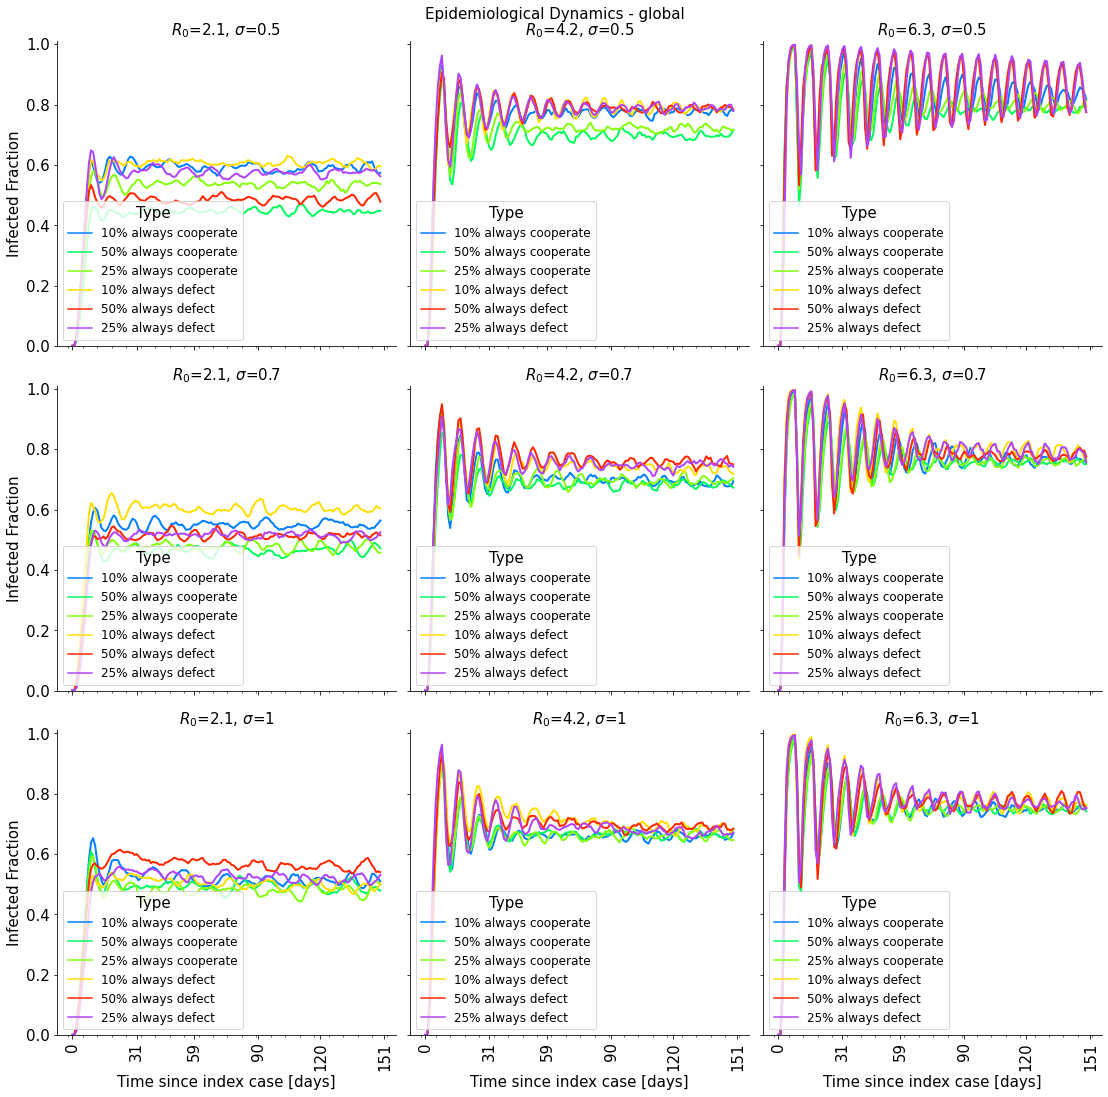

In [26]:
beta_f2    = [0.3, 0.6, 0.9]
ro_f2      = [2.1, 4.2, 6.3]

awareness_f2 = [0.5, 0.7, 1]

fig, ax = plt.subplots(3, 3, figsize=(15.5, 15.5), sharex=True, sharey=True)
type_s = "global"

import pylab 

cm = pylab.get_cmap('gist_ncar') 
for idx_b, beta in enumerate(beta_f2):
    for idx_s, sigma in enumerate(awareness_f2):

        df_response_plt = df_response[df_response.beta==beta].copy()
        df_response_plt = df_response_plt[df_response_plt.sigma==sigma].copy()
        #df_response_plt = df_response_plt[df_response_plt.function==ttype]
        df_response_plt = df_response_plt[df_response_plt.type==type_s]

        sns.lineplot(ax=ax[idx_s, idx_b], data=df_response_plt.reset_index(), x="time", y="I", hue="strategy", palette="gist_ncar", lw=2)
        ax[idx_s, idx_b].set_ylim([0, 1.01])
        ax[idx_s, idx_b].set_title(r"$R_0$={}, $\sigma$={}".format(ro_f2[idx_b], sigma), fontsize=15)

for axi in ax.flatten():
    axi.xaxis.set_major_locator(mdates.MonthLocator())
    axi.xaxis.set_minor_locator(mdates.WeekdayLocator())
    axi.tick_params( which='both', axis='both', labelsize=15)
    axi.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_xlabel("Time since index case [days]", fontsize=15)
    axi.set_ylabel("Infected Fraction", fontsize=15)
    # if ro_f2[idx_b] == 2.1:
    axi.legend(fontsize=12, title="Type", title_fontsize=15, loc="lower left")
    # else:
        # axi.legend(fontsize=15, title="Type", title_fontsize=15, loc="lower right")

fig.suptitle(f"Epidemiological Dynamics - {type_s}", fontsize=15) 
plt.tight_layout()
fig.savefig("{}_nonelastic_infected_grid_r0sigma.pdf".format(type_s),  dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)


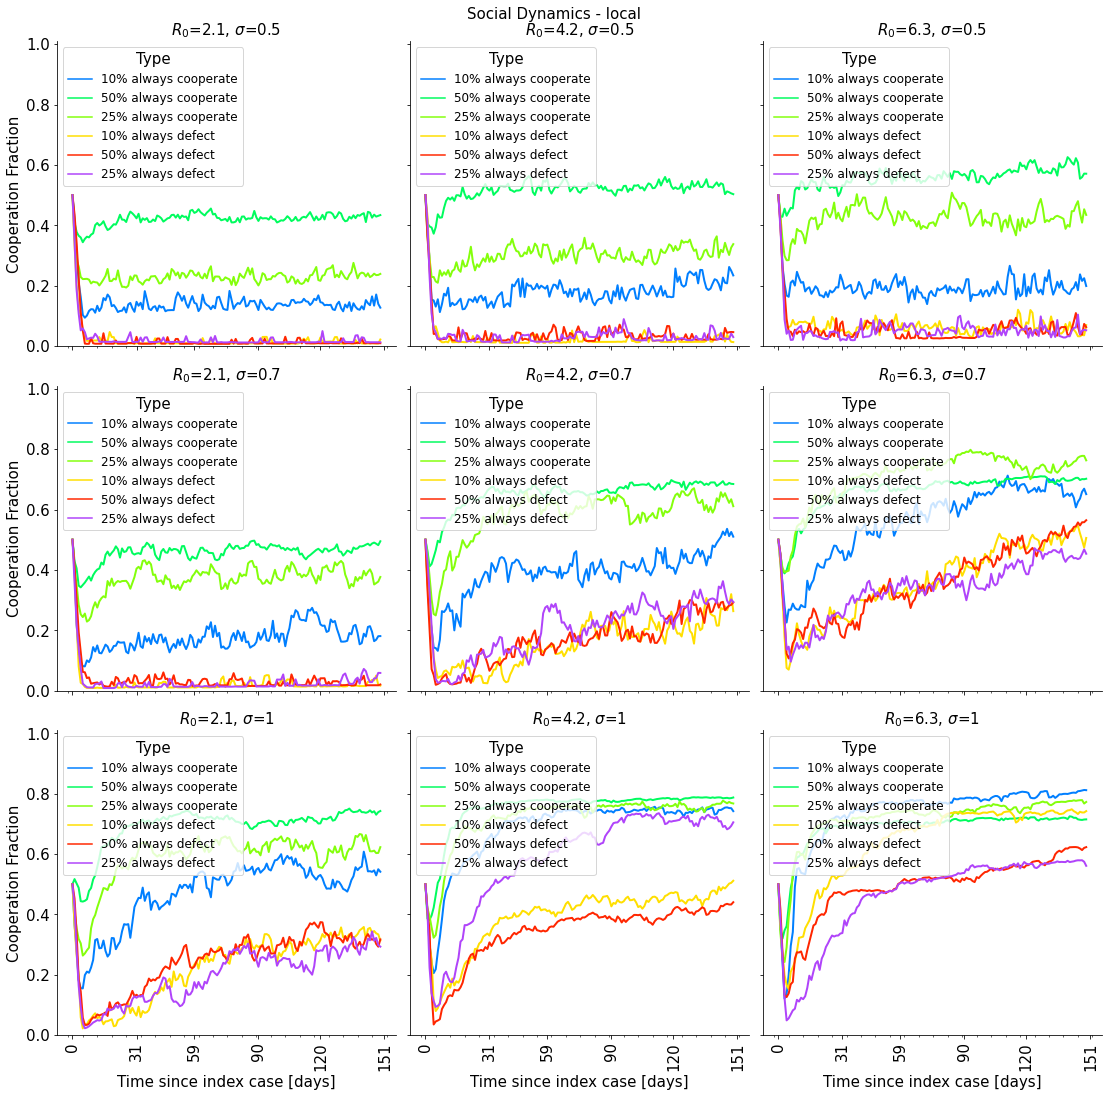

In [29]:
beta_f2    = [0.3, 0.6, 0.9]
ro_f2      = [2.1, 4.2, 6.3]

awareness_f2 = [0.5, 0.7, 1]

fig, ax = plt.subplots(3, 3, figsize=(15.5, 15.5), sharex=True, sharey=True)
type_s = "local"

import pylab 

cm = pylab.get_cmap('gist_ncar') 
for idx_b, beta in enumerate(beta_f2):
    for idx_s, sigma in enumerate(awareness_f2):

        df_response_plt = df_response[df_response.beta==beta].copy()
        df_response_plt = df_response_plt[df_response_plt.sigma==sigma].copy()
        #df_response_plt = df_response_plt[df_response_plt.function==ttype]
        df_response_plt = df_response_plt[df_response_plt.type==type_s]

        sns.lineplot(ax=ax[idx_s, idx_b], data=df_response_plt.reset_index(), x="time", y="C", hue="strategy", palette="gist_ncar", lw=2)
        ax[idx_s, idx_b].set_ylim([0, 1.01])
        ax[idx_s, idx_b].set_title(r"$R_0$={}, $\sigma$={}".format(ro_f2[idx_b], sigma), fontsize=15)

for axi in ax.flatten():
    axi.xaxis.set_major_locator(mdates.MonthLocator())
    axi.xaxis.set_minor_locator(mdates.WeekdayLocator())
    axi.tick_params( which='both', axis='both', labelsize=15)
    axi.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_xlabel("Time since index case [days]", fontsize=15)
    axi.set_ylabel("Cooperation Fraction", fontsize=15)
    # if ro_f2[idx_b] == 2.1:
    axi.legend(fontsize=12, title="Type", title_fontsize=15, loc="upper left")
    # else:
        # axi.legend(fontsize=15, title="Type", title_fontsize=15, loc="lower right")

fig.suptitle(f"Social Dynamics - {type_s}", fontsize=15) 
plt.tight_layout()
fig.savefig("{}_nonelastic_cooperation_grid_r0sigma.pdf".format(type_s),  dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)
